In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as si
import datetime
import matplotlib.pyplot as plt
import time
import asyncio
import nest_asyncio
import requests
import bs4 as bs
from requests_html import AsyncHTMLSession
from nltk.sentiment.vader import SentimentIntensityAnalyzer

session = AsyncHTMLSession()

# Creating the Necessary Methods

In [2]:
def black_scholes_model(S: float, K: int, T: float, r: float, sigma: float) -> float:
    """
    S: Current price of the underlying asset
    K: Strike price of the option
    T: Time to expiration in years
    r: Risk-free interest rate
    sigma: Volatility of the underlying asset

    Returns:
        Call Price
    """
    if sigma == 0:
        return 0
    
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    N_d1 = si.norm.cdf(d1)
    N_d2 = si.norm.cdf(d2)
    call = S * N_d1 - K * np.exp(-r * T) * N_d2
    
    return call

In [3]:
def time_exp(input_date: str, input_expiration_date: str) -> float:
    """
    input_date: Input date provided
    input_expiration_date: Expiration date of the option

    Returns: 
        Time to Expiration
    """
    trade_date = datetime.datetime.strptime(input_date, '%Y-%m-%d %H:%M:%S%z').date()
    expiration_date = datetime.datetime.strptime(input_expiration_date, '%Y-%m-%d').date()
    time_to_expiration = (expiration_date - trade_date).days / 365.25
    
    return time_to_expiration

In [4]:
def assign_weight(score: int) -> float:
    """
    Assigns a weight to a value.

    Returns: 
        The weight
    """
    if score < 0:
        return 1 + abs(score)
    elif score > 0:
        return 1 + score
    else:
        return 1

In [5]:
def sp500_tickers() -> list:
    """
    Get's a list of the S&P 500 tickers from wikipedia.

    Returns: 
        List of tickers
    """
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})

    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        ticker = ticker[:-1]
        if "." in ticker:
            ticker = ticker.replace('.', '-')
        tickers.append(ticker)

    return tickers

In [6]:
def yahoo_news_retriever(ticker: str) -> pd.DataFrame:
    """
    Gets a list of news articles related to the ticker from yahoo finance.

    Returns:
        Dataframe of article headlines
    """

    yahoo_ticker_list = []
    all_yahoo_news_headlines = []
    all_yahoo_news_dates = []

    for news in yf.Ticker(ticker).news:
        title_yahoo = news['title'].rstrip('\\').replace('$', '\$')
        news_date_yahoo = str(datetime.datetime.fromtimestamp(news['providerPublishTime']).date())

        yahoo_ticker_list.append(ticker)
        all_yahoo_news_headlines.append(title_yahoo)
        all_yahoo_news_dates.append(news_date_yahoo)

        time.sleep(0.1)

    yahoo_articles = pd.DataFrame({'ticker': yahoo_ticker_list, 'date': all_yahoo_news_dates, 'headline': all_yahoo_news_headlines})
    
    return yahoo_articles

In [7]:
async def google_news_retriever(ticker: str) -> pd.DataFrame:
    """
    Gets a list of news articles related to the ticker from google news.

    Returns:
        Dataframe of article headlines
    """
    
    google_ticker_list = []
    all_google_news_headlines = []
    all_google_news_dates = []

    url = f"https://news.google.com/search?q={ticker.upper()}%20stock&hl=en-US&gl=US&ceid=US%3Aen"

    while True:
        r = await session.get(url)
        await r.html.arender(sleep = 1, scrolldown = 0, timeout = 20)
        articles = r.html.find('article')

        for item in articles:
            try:
                news_item = item.find('h3', first = True)
                title_google = news_item.text
                news_date_element = item.find('time')[0]
                news_date_str = str(news_date_element.attrs['datetime']).replace('T', ' ').replace('Z', '')
                news_date_google = datetime.datetime.strptime(news_date_str, '%Y-%m-%d %H:%M:%S').date()

                google_ticker_list.append(ticker)
                all_google_news_headlines.append(title_google)
                all_google_news_dates.append(news_date_google)
                    
            except:
                pass
        
        else:
            break
    
    google_articles = pd.DataFrame({'ticker': google_ticker_list, 'date': all_google_news_dates, 'headline': all_google_news_headlines})

    return google_articles

In [8]:
nest_asyncio.apply()

async def run_google_news_retriever(ticker: str):
    """
    Function to run the google_news_retriever method to prevent any coroutine
    errors.

    Returns:
        Dataframe of article headlines
    """
    
    articles_list = await google_news_retriever(f'{ticker}')
    
    return articles_list

# Defining Relevant Variables and Getting the Data for Individual Ticker

In [9]:
expiration_date = '2023-06-16'
risk_free_interest_rate = 0.0512
user_ticker = 'F'

In [10]:
try:
    ticker_data = yf.download(f'{user_ticker.upper()}', period = '1d', progress = False)
    underlying_asset_price = ticker_data['Adj Close'].iloc[-1]

    option_chain = yf.Ticker(user_ticker.upper()).option_chain(expiration_date)
    ticker_options_data = pd.DataFrame(option_chain.calls)
    ticker_options_data['ticker'] = user_ticker.upper()
    ticker_options_data['underlyingPrice'] = underlying_asset_price
    
except:
    print('Options data not available.')


## Calculating Black Scholes Price

In [11]:
ticker_bs_call_list = []
for index, row in ticker_options_data.iterrows():
    S = row['underlyingPrice']
    K = row['strike']
    T = time_exp(str(row['lastTradeDate']), expiration_date)
    r = risk_free_interest_rate
    sigma = row['impliedVolatility']
    ticker_bs_call_price = black_scholes_model(S, K, T, r, sigma)
    ticker_bs_call_list.append(ticker_bs_call_price)

ticker_options_data['BSP'] = ticker_bs_call_list
ticker_options_data = ticker_options_data[['ticker', 'underlyingPrice', 'lastTradeDate', 'strike', 'lastPrice', 'BSP', 
                                           'bid', 'ask', 'volume', 'openInterest', 'impliedVolatility']]

ticker_options_data.head()

,ticker,underlyingPrice,lastTradeDate,strike,lastPrice,BSP,bid,ask,volume,openInterest,impliedVolatility
0,F,14.05,2023-06-07 18:15:52+00:00,2.35,11.10,11.998953,11.65,11.75,2.0,18,8.687505
1,F,14.05,2023-02-09 20:06:39+00:00,3.00,10.45,11.102935,0.00,0.00,46.0,12,0.000010
2,F,14.05,2023-06-02 14:52:16+00:00,3.35,9.05,11.131485,10.65,10.80,1.0,1,6.187502
3,F,14.05,2022-12-22 18:14:34+00:00,4.00,7.20,10.147478,8.30,8.50,NaN,1,0.000010
4,F,14.05,2023-06-09 14:50:29+00:00,4.35,9.54,9.812430,9.70,9.75,2.0,24,5.125004


## Getting the News Articles for the Specified Ticker

In [12]:
if ticker_options_data.empty:
    print('No options data available, so no news articles.')
else:
    google_news = asyncio.run(google_news_retriever(f'{user_ticker}'))
    yahoo_news = yahoo_news_retriever(f'{user_ticker}')

    clean_news = pd.concat([google_news, yahoo_news]).drop_duplicates(subset = 'headline').reset_index(drop = True)

clean_news.head()

,ticker,date,headline
0,F,2023-06-12,Should Value Investors Buy Ford Motor (F) Stock?
1,F,2023-06-11,3 Good Reasons to Buy Ford Stock Right Now
2,F,2023-06-12,F: Is June the Time to Buy or Hold Ford Motor ...
3,F,2023-06-13,"Tesla, Amazon, Ford stocks rise more as tame i..."
4,F,2023-06-07,Is Ford Motor Co (F) Stock Over or Undervalued?


## Using VADER to get Sentiment Scores of Headlines

In [13]:
vader = SentimentIntensityAnalyzer()

ticker_scores = clean_news['headline'].apply(vader.polarity_scores).tolist()
ticker_sentiment_scores_df = pd.concat([clean_news, pd.DataFrame(ticker_scores)], axis = 1)

ticker_sentiment_scores_df.head()

,ticker,date,headline,neg,neu,pos,compound
0,F,2023-06-12,Should Value Investors Buy Ford Motor (F) Stock?,0.0,0.745,0.255,0.3400
1,F,2023-06-11,3 Good Reasons to Buy Ford Stock Right Now,0.0,0.707,0.293,0.4404
2,F,2023-06-12,F: Is June the Time to Buy or Hold Ford Motor ...,0.0,1.000,0.000,0.0000
3,F,2023-06-13,"Tesla, Amazon, Ford stocks rise more as tame i...",0.0,0.761,0.239,0.5267
4,F,2023-06-07,Is Ford Motor Co (F) Stock Over or Undervalued?,0.0,1.000,0.000,0.0000


## Normalizing the Sentiment Scores and Giving them a Weight

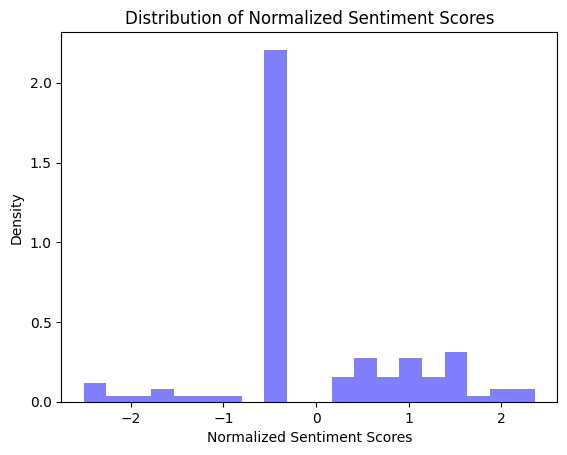

In [14]:
ticker_sentiment_scores_df['normalized_sentiment_score'] = (ticker_sentiment_scores_df['compound'] - ticker_sentiment_scores_df['compound'].mean()) / \
    (ticker_sentiment_scores_df['compound'].std())
ticker_sentiment_scores_df['weight'] = ticker_sentiment_scores_df['compound'].apply(assign_weight)

plt.hist(ticker_sentiment_scores_df['normalized_sentiment_score'], bins = 20, density = True, color = 'blue', alpha = 0.5)
plt.title('Distribution of Normalized Sentiment Scores')
plt.xlabel('Normalized Sentiment Scores')
plt.ylabel('Density')

plt.show()

In [15]:
print(ticker_sentiment_scores_df['normalized_sentiment_score'].mean())
print(ticker_sentiment_scores_df['normalized_sentiment_score'].median())

-2.8279265721584176e-17
-0.43417189017078833


In [16]:
ticker_options_data['adjustedVolatility'] = ticker_options_data['impliedVolatility'] \
    * (1 + ticker_sentiment_scores_df['weight'] * ticker_sentiment_scores_df['normalized_sentiment_score'].median())

## Calculating Adjusted Black Scholes Price

In [17]:
adj_bs_call_list = []
for index, row in ticker_options_data.iterrows():
    S = row['underlyingPrice']
    K = row['strike']
    T = time_exp(str(row['lastTradeDate']), expiration_date)
    r = risk_free_interest_rate
    sigma = row['adjustedVolatility']
    adj_bs_call_price = black_scholes_model(S, K, T, r, sigma)
    adj_bs_call_list.append(adj_bs_call_price)

ticker_options_data['adjBSP'] = adj_bs_call_list

ticker_options_data.head()

,ticker,underlyingPrice,lastTradeDate,strike,lastPrice,BSP,bid,ask,volume,openInterest,impliedVolatility,adjustedVolatility,adjBSP
0,F,14.05,2023-06-07 18:15:52+00:00,2.35,11.10,11.998953,11.65,11.75,2.0,18,8.687505,3.633198,11.703700
1,F,14.05,2023-02-09 20:06:39+00:00,3.00,10.45,11.102935,0.00,0.00,46.0,12,0.000010,0.000004,11.102935
2,F,14.05,2023-06-02 14:52:16+00:00,3.35,9.05,11.131485,10.65,10.80,1.0,1,6.187502,3.501063,10.736015
3,F,14.05,2022-12-22 18:14:34+00:00,4.00,7.20,10.147478,8.30,8.50,NaN,1,0.000010,0.000003,10.147478
4,F,14.05,2023-06-09 14:50:29+00:00,4.35,9.54,9.812430,9.70,9.75,2.0,24,5.125004,2.899871,9.705809


In [18]:
trade_date_list = []
trade_time_list = []

for i in ticker_options_data['lastTradeDate']:
    trade_date = datetime.datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S%z').date()
    trade_date_list.append(trade_date)
    trade_time = datetime.datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S%z').time()
    trade_time_list.append(trade_time)
    
ticker_options_data['tradeDate'] = trade_date_list
ticker_options_data['tradeTime'] = trade_time_list

In [19]:
final_options_data = ticker_options_data[['ticker', 'underlyingPrice', 'tradeDate', 'tradeTime', 'strike' , 'lastPrice', 'BSP', 'adjBSP', 
                                          'bid', 'ask', 'volume', 'openInterest', 'impliedVolatility', 'adjustedVolatility']]
final_options_data = final_options_data.copy()
final_options_data = final_options_data.rename({'BSP': 'orgBSP'}, axis = 1)
final_options_data.head()

,ticker,underlyingPrice,tradeDate,tradeTime,strike,lastPrice,orgBSP,adjBSP,bid,ask,volume,openInterest,impliedVolatility,adjustedVolatility
0,F,14.05,2023-06-07,18:15:52,2.35,11.10,11.998953,11.703700,11.65,11.75,2.0,18,8.687505,3.633198
1,F,14.05,2023-02-09,20:06:39,3.00,10.45,11.102935,11.102935,0.00,0.00,46.0,12,0.000010,0.000004
2,F,14.05,2023-06-02,14:52:16,3.35,9.05,11.131485,10.736015,10.65,10.80,1.0,1,6.187502,3.501063
3,F,14.05,2022-12-22,18:14:34,4.00,7.20,10.147478,10.147478,8.30,8.50,NaN,1,0.000010,0.000003
4,F,14.05,2023-06-09,14:50:29,4.35,9.54,9.812430,9.705809,9.70,9.75,2.0,24,5.125004,2.899871


## Analysis of the Last Price, Original BSP, and Adjusted BSP

In [20]:
final_options_data[['lastPrice', 'orgBSP', 'adjBSP']].describe()

,lastPrice,orgBSP,adjBSP
count,64.000000,64.000000,6.400000e+01
mean,2.334219,2.891893,2.652767e+00
std,3.198512,3.615694,3.562223e+00
min,0.010000,0.001347,2.865887e-36
25%,0.010000,0.036097,4.591283e-05
50%,0.085000,0.896723,4.611878e-01
75%,4.182500,5.078849,4.793628e+00
max,11.100000,11.998953,1.170370e+01


In [21]:
adj_last = final_options_data['adjBSP'].mean() - final_options_data['lastPrice'].mean()
org_last = final_options_data['orgBSP'].mean() - final_options_data['lastPrice'].mean()
org_adj = final_options_data['orgBSP'].mean() - final_options_data['adjBSP'].mean()

print(f"Difference in Means of (Adjusted BSP - Last Price) = {adj_last}")
print(f"Difference in Means of (Original BSP - Last Price) = {org_last}")
print(f"Difference in Means of (Original BSP - Adjusted BSP) = {org_adj}")

Difference in Means of (Adjusted BSP - Last Price) = 0.3185479970595586
Difference in Means of (Original BSP - Last Price) = 0.5576741083270802
Difference in Means of (Original BSP - Adjusted BSP) = 0.2391261112675216


In [22]:
wilcoxon_stat_adj, p_value_adj_wil = si.wilcoxon(final_options_data['adjBSP'], final_options_data['lastPrice'])
wilcoxon_stat_org, p_value_org_wil = si.wilcoxon(final_options_data['orgBSP'], final_options_data['lastPrice'])

print("Wilcoxon signed-rank test results:")
print("Adjusted BSP vs. Last Price:")
print("\tStatistic:", wilcoxon_stat_adj)
print("\tP-Value:", p_value_adj_wil)
print("Original BSP vs. Last Price:")
print("\tStatistic:", wilcoxon_stat_org)
print("\tP-Value:", p_value_org_wil)

Wilcoxon signed-rank test results:
Adjusted BSP vs. Last Price:
	Statistic: 988.0
	P-Value: 0.7280277591922519
Original BSP vs. Last Price:
	Statistic: 451.0
	P-Value: 8.184230024088996e-05


# Analysis for All the Tickers in S&P500

In [23]:
wilcoxen_results = pd.DataFrame(pd.read_csv('wilcoxen_test.csv'))
wilcoxen_results

,ticker,wilcoxon_stat_adj,p_value_adj_wil,wilcoxon_stat_org,p_value_org_wil
0,A,48.0,0.190094,39.0,0.079681
1,AAL,367.0,0.418289,367.0,0.418289
2,AAP,1030.0,0.001206,1037.0,0.001349
3,AAPL,780.0,0.558594,761.0,0.464381
4,ABBV,668.0,0.674114,710.0,0.961166
...,...,...,...,...,...
498,YUM,43.0,0.066536,30.0,0.013870
499,ZBH,41.0,0.175354,37.0,0.116669
500,ZBRA,45.0,1.000000,36.0,0.541748
501,ZION,213.0,0.007264,244.0,0.024973


In [28]:
adj_tickers = []
org_tickers = []

for index, row in wilcoxen_results.iterrows():
    if row['p_value_adj_wil'] > 0.05:
        print(f"{row['ticker']} Adjusted BSP is better")
        adj_tickers.append(row['ticker'])
    elif row['p_value_org_wil'] > 0.05:
        print(f"{row['ticker']} Original BSP is better")
        org_tickers.append(row['ticker'])
    elif row['p_value_adj_wil'] is np.nan:
        print('No value')

print(f"{len(adj_tickers)}, {len(org_tickers)}")

A Adjusted BSP is better
AAL Adjusted BSP is better
AAPL Adjusted BSP is better
ABBV Adjusted BSP is better
ABT Adjusted BSP is better
ACGL Adjusted BSP is better
ADM Original BSP is better
AEE Adjusted BSP is better
AEP Original BSP is better
AES Original BSP is better
AIZ Adjusted BSP is better
AKAM Adjusted BSP is better
ALB Adjusted BSP is better
ALGN Adjusted BSP is better
ALK Adjusted BSP is better
ALLE Adjusted BSP is better
AMCR Adjusted BSP is better
AME Adjusted BSP is better
AMGN Adjusted BSP is better
AMT Adjusted BSP is better
AMZN Original BSP is better
ANET Adjusted BSP is better
ANSS Adjusted BSP is better
AON Adjusted BSP is better
AOS Adjusted BSP is better
APA Original BSP is better
APH Adjusted BSP is better
APTV Adjusted BSP is better
ARE Adjusted BSP is better
ATO Adjusted BSP is better
AVB Adjusted BSP is better
AVY Original BSP is better
AWK Adjusted BSP is better
AXON Original BSP is better
BA Adjusted BSP is better
BALL Adjusted BSP is better
BAX Adjusted BSP 